# SLU09: Model Selection & Overfitting
---
<a id='top'></a>

In this notebook we will cover the following:

### 1. [Generalization Error](#generror)
### 2. [Model Selection](#modelselection)
### 3. [Regularized Linear Regression](#regularization)
    

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Introduction: The need for validation  

Before we jump into definitions, let's try to get a couple of intuitions going. 

To do so, let's answer the question: 

> **"How does the number of hours of TV per day relate to a person's age?"**

In [2]:
df = utils.generate_time_on_tv()

As usual, we'll start with a little plot: 

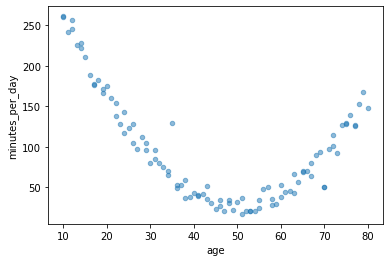

In [3]:
fig, ax = plt.subplots()
df.plot(kind='scatter', x='age', y='minutes_per_day', ax=ax, alpha=.5);

Great! We can notice there is a clear pattern here. 

Now we will model it. 

### High bias 
We will use a very "inflexible" model, simple linear regression (linear regression with just one explanatory variable). Simple linear regression requires that the answer be of the format

$$ y = \beta x + c $$

So let's try that... 

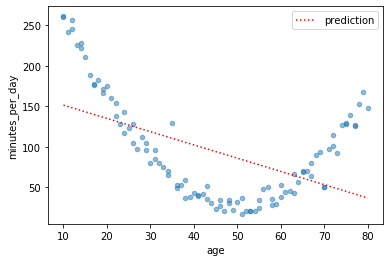

In [4]:
utils.fit_lin_reg(df)

This is no good! The reason is simple: our model had too many assumptions about the data ahead of time. It had too much **bias**.

In machine learning terms, we say we've **underfit the data**. 

### High Variance
Now, in normal life the word "bias" has a negative connotation.

So if bias is bad, maybe we should get rid of as much bias as we can, and just let the data speak for itself! Right? Ehm... 

We'll use a really high variance algo _(don't worry about which one just yet)_:

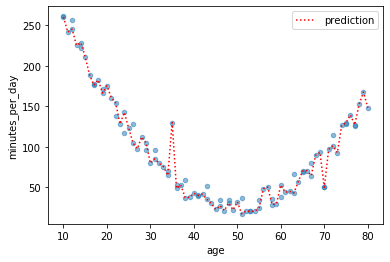

In [5]:
utils.fit_high_variance_algo(df)

Well that's no good either! The model just followed the data like an idiot, doesn't seem to have any sort of bias... oh wait that's what we wanted. 

The learning here is... 

***Bias and Variance are a tradeoff***

A bit of bias is necessary, and not enough will make your model **overfit** to the data.

### Why does this matter?
The goal of building machine learning models is to be able to make accurate predictions on previously unseen data; in other words, we want the model to generalize. 

By having too much bias, the model does not "learn" enough to be accurate on seen (training) data or on unseen (test) data.

By having too much variance, the model may have high accuracy on training data, but it loses its power of generalization. 

<a id='generror'></a>
[Return to top](#top)
# 1. Generalization Error

### Subtopics:
1. **Decomposition**
    1. Bias
    2. Variance
    3. Irreducible error
2. **Bias-variance trade-off**
3. **Sources of complexity**

## 1.1 Decomposing the generalization error

Bias-variance decomposition is a way of analyzing an algorithm's expected generalization error, with respect to the sum of three terms:

1. Bias

2. Variance

3. Irreducible error.

As we will see, dealing with bias and variance is really about under- (high bias) and over-fitting (high variance).

![dart_throwing_bias_var_tradeoff](media/dart_throwing_bias_var_tradeoff.png)

*Fig.: Graphical illustration of bias and variance using dart-throwing, from [Scott Fortmann-Row's "Understanding the Bias-Variance Trade-off"](http://scott.fortmann-roe.com/docs/BiasVariance.html)*

### 1.1.1 Bias and underfitting

Bias results from simplistic assumptions and a lack of malleability: in short, we are missing parameters that would be in a correct model.

Bias is always learning the same wrong thing, skewing predictions consistently across different training samples (i.e., far-off from the real value):

$$ Bias = E\big[\hat{y} - y\big] $$

Fixing bias requires adding complexity to our models to make them more adaptable to the data. 

### 1.1.2 Variance and overfitting

On the other side, extremely flexible models overreact to the specifics of the training data (including the random noise).

Variance creeps in when we have more parameters than justified by the data and learn random things from different training samples:

$$ Variance = E\big[\big(\hat{y} - E[\hat{y}]\big)^2\big] $$

Fixing variance requires decreasing complexity to prevent the model from drifting.
 
### 1.1.3 Irreducible error

Irreducible error is error that cannot be eliminated by building good models. It is essentially a measure of noise in the data. 

## 1.2 The bias-variance tradeoff

There is a trade-off between the bias and variance. In relation to increasing model complexity, bias is reduced while variance increases.

![bias_variance_trade_off](media/bias_variance_trade_off.png)

*Fig.: The bias-variance tradeoff, bias is reduced and variance is increased in relation to model complexity*

In theory, we reach the right level of complexity when the increase in bias is equivalent to the reduction in variance:

$$ \frac{dBias}{dComplexity} = - \frac{dVariance}{dComplexity} $$

In practice, *there is not an analytical way to find this location* and the more we (over)reach for signal, the greater the noise.

## 1.3 Sources of model complexity

Model complexity arises from, among others:
* adding new features
* increasing the polynomial degree of the hypothesis
* using highly flexible models

<a id='modelselection'></a>
[Return to top](#top)
# 2. Model Selection

### Subtopics:

1. **Offline evaluation**
    1. Leave-one-out or hold-out method
        1. [`sklearn.model_selection.train_test_split`](#traintestsplit)
        2. In-sample or training error
        3. Out-of-sample or testing error
        4. [Validation dataset](#valset)
        5. Evaluating overfitting and underfitting
    2. [K-Fold cross-validation](#kfolds)
        1. `sklearn.model_selection.cross_val_score`
    3. [Data leakage](#dataleak)
2. [**Practical considerations**](#practical)
    1. Training time
    2. Prediction time
    3. Memory

# 2.1 Evaluating models 

One way to understand overfitting is by decomposing the generalization error of a model into bias and variance.

We will be using data about craft beer to try to predict whether a particular beer is an [India Pale Ale (IPA)](https://en.wikipedia.org/wiki/India_pale_ale).

The data was preprocessed in advance, as the original dataset was simplified and manipulated for teaching purposes. There are two features:
* `IBU`, which stands for International Bitterness Units and is a measure of bitterness
* `Color`.

![](https://continue.utah.edu/images/widget/lifelong/LLFW529beer-sensory-evaluation.jpg)

In [6]:
data = pd.read_csv('data/beer.csv')
data.head(n=3)

,Color,IBU,IsIPA
0,-0.652164,-0.970233,0
1,-0.377297,1.387356,1
2,0.183752,0.442296,0


In [7]:
X = data[['Color', 'IBU']]
y = data['IsIPA']  # <--- to be an IPA or not to be an IPA, that is the question 

Let's get a quick idea of how the target (IsIPA) varies with the features: 

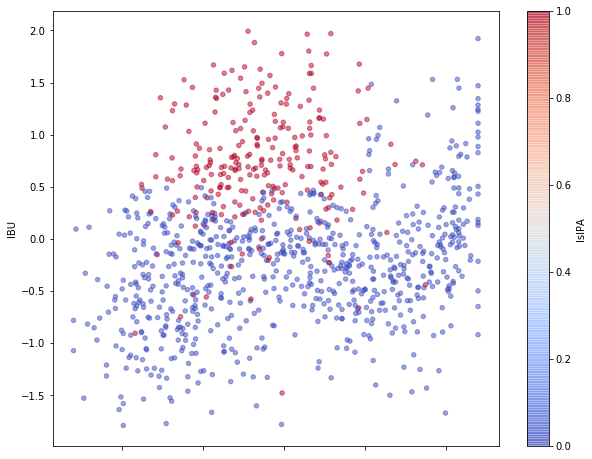

In [8]:
data.plot(kind='scatter', x='Color', y='IBU', c='IsIPA', colormap='coolwarm', figsize=(10, 8), alpha=.5)
plt.show()

We are going to try to model the type of beer (isIPA) by using `Color` and `IBU`. 

We will use 3 classifiers: 

> `SuperConservative` - will have very **low variance**, and **high bias**  
> `SuperFlexible` - Will have very **high variance**, and **low bias**   
> `WellBalanced` - Will be juuuust right 

We will then calculate the accuracy of each of the classifiers. 

###  `SuperConservative` (high bias) 

For our `SuperConservative` model we will use a `Logistic Regression`. 

Logistic regression provides an example of bias because it makes a lot of assumptions about the form of the target function.

Visually, we can understand the model's inability to adjust to a non-linear decision boundary, structurally enforcing a linear one instead.

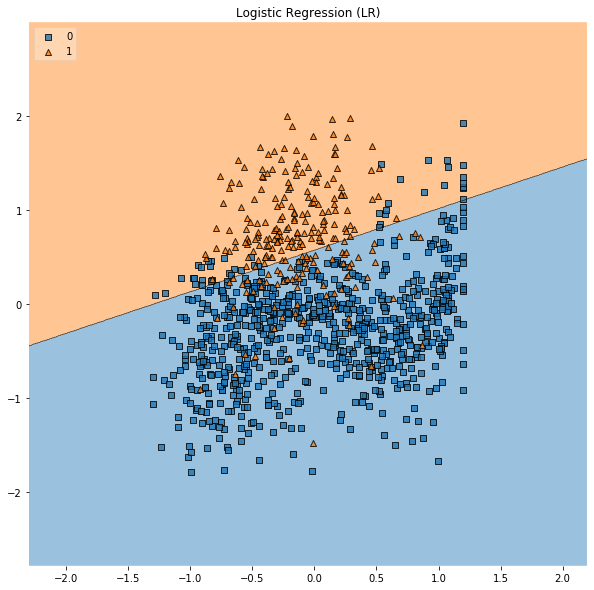

In [9]:
utils.plot_super_conservative(X, y)

It actually doesn't do too badly, but when we look at the "right side" we can tell it is probably blue all the way to the top, right? 

Let's give it tons of flexibility! 

### `SuperFlexible` (high variance)  

For our super flexible model, we will use a `k-Nearest Neighbors` with k=1 (don't worry about what this is yet!)

The k-Nearest neighbors algorithm provides great flexibility and minimum underlying structure.

The small orange *pockets* or *islands* show that our model is overadapting to the training data and, most probably, fitting to noise.

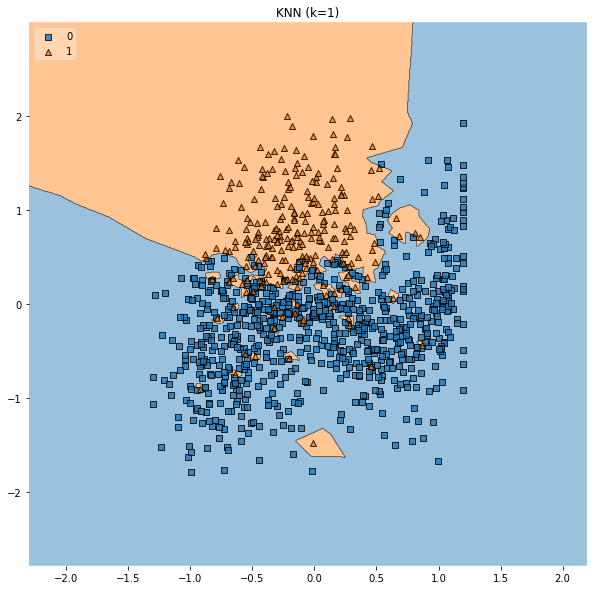

In [10]:
utils.plot_super_flexible(X, y)

Oh. Right. It definitely figured out that the top right is blue, but it also did some pretty crazy things. It's pretty clear that it's fitting noise. 

### `WellBalanced` (sort of better)

For the well balanced one, we will use a `K-Nearest Neighbors` with k=9 

A key part of the k-NN algorithm is the choice of *k*: the number of nearest numbers in which to base the prediction.

Increasing *k* results in considering more observations in each prediction and makes the model more rigid, for good effect.

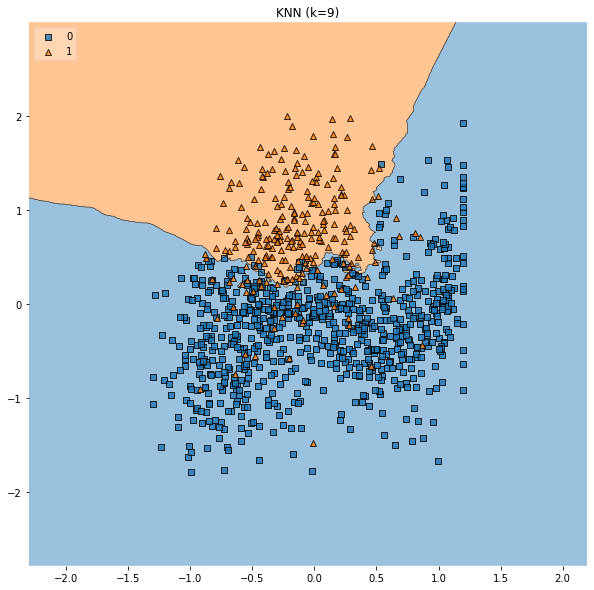

In [11]:
utils.plot_just_right(X, y)

### So... how do we choose? 

The irony is that if we were to calculate the accuracy (or any other metric) of these models, our best one would be... `SuperFlexible`! The reason is simple: it has clearly overfit the data, but if we evaluate it, we're using that data again, so it will be right. 

Plotting helps us see that, but comparing different models by plotting decision boundaries is not very scientific, especially at higher dimensions.

There must be a better way!

### The need for validation

Given the above, we need to validate our models after training, to know if they are any good:
1. Our assumptions may not hold (that is, we trained a garbage model) or there may be better models
2. We may be learning parameters that don't generalize for the entire population (i.e., statistical noise).

Remember, our goal is to approximate the true, universal target function *f* and we need our model to generalize to unseen data.

<a id='traintestsplit'></a> [Top of section](#modelselection)
## 2.1.1 Train-test split (holdout method)

The most obvious way to solve this problem is to separate your dataset into two parts: 
- the training set, where we will find out which model to use 
- the test set, where we will make sure we didn't just overfit the training set 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Machine_learning_nutshell_--_Split_into_train-test_set.svg/2000px-Machine_learning_nutshell_--_Split_into_train-test_set.svg.png" width="400">


This is the most basic approach, and there are others which are superior to it. However, from a basic data science perspective, having a test set which is only used at the end is one of the most sacred concepts. 

Someone brilliant (and whose name I can't recall) once said: 
> _**"Every time you use your test set your data dies a little"**_

That is because every time you use your test set you lose the ability to tell whether you are overfitting the data you happen to have at hand. 

### In-sample-error (ISE) or training error


The in-sample-error is how well our model performs on the training data.

We will measure the error rate for each model in the simplest way, by computing the fractions of misclassified cases.

Remember our 3 classifiers? Let's calculate the in-sample-error for each: 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [13]:
clfs = {'SuperConservative': LogisticRegression(),
        'WellBalanced': KNeighborsClassifier(n_neighbors=9),
        'SuperFlexible': KNeighborsClassifier(n_neighbors=1)}

In [14]:
from sklearn.metrics import accuracy_score

def classification_error(clf, X, y):
    y_pred = clf.predict(X)
    error_rate = 1 - accuracy_score(y, y_pred)
    return round(error_rate * 100, 2)

We will make the first 800 rows (80%) training data 

In [15]:
X_train = X[:800]
y_train = y[:800]

We will make the last 200 rows (20%) test data  

In [16]:
X_test = X[801:]
y_test = y[801:]

Testing our model's performance on the training data is a common mistake and underestimates the generalization error.

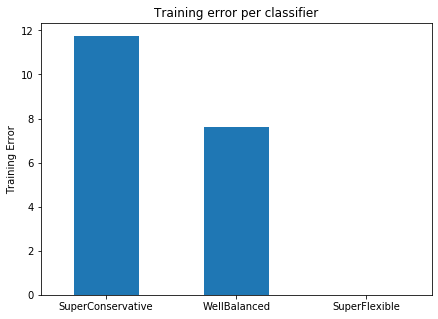

In [17]:
training_error = {}
for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error[key] = classification_error(clf, X_train, y_train)

pd.Series(training_error).plot(figsize=(7, 5), kind='bar', rot=0)
plt.ylabel('Training Error')
plt.title('Training error per classifier')
plt.show()

I mean, clearly the `SuperFlexible` model is the best one! Right? (wrong, as we've seen before).

Next, we'll measure the out of sample error of each of the models. 

### Out-of-sample error (OSE) or testing error

The out-of-sample error measures how well the model performs on previsouly unseen data and if it's picking up patterns that generalize well.

Ideally, both training and test errors are low and close to one another.

* *Underfitted* models tend to perform poorly on both train and test data, having large (and similar) in-sample- and out-of-sample errors.

* *Overfitting* is detected when a model that performs on training data but not quite so well in the test set: the bigger the gap, the greater the overfitting.

![train_test_error](media/train_test_error.png)

*Fig.: How training and test errors behave in regards to model complexity, bias and variance*

But okay, let's see how our models perform on the test set.

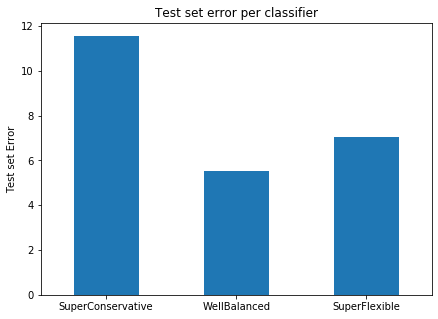

In [18]:
test_set_error = {}
for key, clf in clfs.items():
    test_set_error[key] = classification_error(clf, X_test, y_test)

pd.Series(test_set_error).plot(figsize=(7, 5), kind='bar', rot=0)
plt.ylabel('Test set Error')
plt.title('Test set error per classifier')
plt.show()

There are different techniques to measure the testing error, we will focus on:
1. Train-test split
2. Validation set
3. Cross-validation
4. Bootstrapping.

### Train-test split (aka holdout method)

The best possible solution is to leave a random subset of the data aside from the beginning to test our final model at the end.

![test_set](media/test_set.png)

*Fig.: Test set illustrated, you holdout a significant chunk of the data for testing your model in the end*


![train_test_set](media/train_test_split.png)

*Fig.: Workflow with test and training sets*

After evaluation, relearn your final model on the whole data.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print("---\nNumber of observations:\nTrain: {} | Test: {}".format(X_train.shape[0], X_test.shape[0]))

---
Number of observations:
Train: 600 | Test: 400


In [20]:
def compute_metrics(X_train, y_train, X_test, y_test, clf):
    training_error = classification_error(clf, X_train, y_train)
    test_error = classification_error(clf, X_test, y_test)
    return training_error, test_error

for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
    print('---\n{} error:\nTrain: {:5}% | Test: {}%'.format(key, training_error, test_error))

---
SuperConservative error:
Train: 12.67% | Test: 10.5%
---
WellBalanced error:
Train:   7.0% | Test: 8.5%
---
SuperFlexible error:
Train:   0.0% | Test: 11.25%


<a id='valset'></a> [Top of section](#modelselection)
### Validation set

Given we have enough data, we can create a *validation dataset*.

![validation_set](media/validation_set.png)

*Fig.: Validation set as compared with the holdout approach*

![validation_split](media/validation_split.png)

*Fig.: Workflow with test, validation and training sets*

In [21]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)
del X_temp, y_temp

print("Number of observations:\nTrain: {} | Test: {} | Validation: {}"\
      .format(X_train.shape[0], X_test.shape[0], X_val.shape[0]))

Number of observations:
Train: 600 | Test: 200 | Validation: 200


In [22]:
def compute_validation_metrics(X_train, y_train, X_test, y_test, X_validation, y_validation, clf):
    training_error, test_error = compute_metrics(X_train, y_train, X_test, y_test, clf)
    validation_error = classification_error(clf, X_validation, y_validation)
    return training_error, test_error, validation_error

for key, clf in clfs.items():
    clf.fit(X_train, y_train)
    training_error, test_error, validation_error = compute_validation_metrics(
                                        X_train, y_train, X_test, y_test, X_val, y_val, clf)
    print('---\n{} error:\nTrain: {:5}% | Validation: {:4}% | Test: {:4}%'\
          .format(key, training_error, validation_error, test_error))

---
SuperConservative error:
Train:  11.5% | Validation: 13.0% | Test: 10.0%
---
WellBalanced error:
Train:  7.33% | Validation:  7.0% | Test:  8.0%
---
SuperFlexible error:
Train:   0.0% | Validation: 12.0% | Test: 11.5%


You might be wondering, how is this validation set different from the test set? Don't we basically just have two test sets?

Typically, a validation set will be used to tune parameters of the model, and then final evaluation of OSE will be done on the test set. 

We can use the validation set we created above to find the optimal value of *k* for our KNN classifier. 

Again, don't worry about what this means exactly, just know that with increasing *k*, the model becomes less flexible.

In [23]:
# store the errors
error_dict = {}
# store the classifiers so we can retrieve the best one later
clf_dict = {}
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_error, validation_error = compute_metrics(X_train, y_train, X_val, y_val, knn)
    error_dict[k] = {'train_error': train_error, 'validation_error': validation_error}
    clf_dict[k] = knn

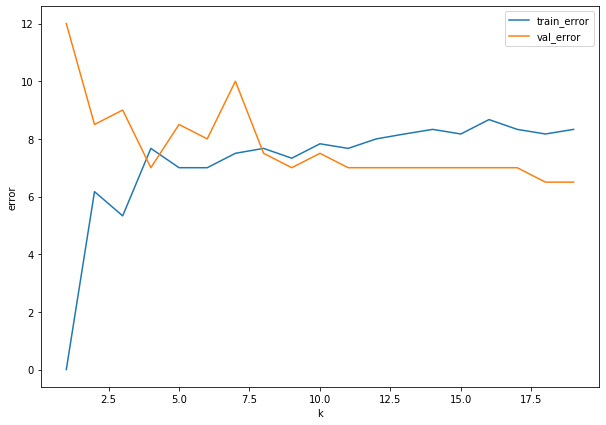

In [24]:
plt.figure(figsize=(10,7))
plt.plot(list(error_dict.keys()), [d['train_error'] for d in error_dict.values()], label='train_error')
plt.plot(list(error_dict.keys()), [d['validation_error'] for d in error_dict.values()], label='val_error')
plt.xlabel('k')
plt.ylabel('error')
plt.legend();

Judging by the graph, it looks like `k=10` is actually the best! Now we will use this value for *k* in evaluating the test set.

In [25]:
knn_10 = clf_dict[10]
test_error = classification_error(knn_10, X_test, y_test)
print('KNN, k=10 error:\nTrain: {:5}% | Validation: {:4}% | Test: {:4}%'\
          .format(error_dict[10]['train_error'], error_dict[10]['validation_error'], test_error))

KNN, k=10 error:
Train:  7.83% | Validation:  7.5% | Test:  6.0%


This is pretty cool! We were able to tune the parameter *k* on our validation set, and the OSE (test error) actually dropped from the `WellBalanced` (k=9) model we trained before!

<a id='kfolds'></a> [Top of section](#modelselection)
## 2.1.2 k-Fold Cross-validation

Test error results can be subject to great variability, especially for smaller datasets, depending on how we split the data (i.e., which observations go where).

Also, and quite obviously, holding out *more* data reduces the amount available for training, possibly leading us to *overestimate* the test error.

In *k*-fold cross validation:
1. The original sample is randomly partitioned into *k* equal sized parts, or subsamples

2. Each time, we leave out part *k*, fit the model to the other *k*-1 subsets combined in a single dataset, and then test the model against the left out *k*th part

3. This is done for each *k* = 1, 2, ..., *K*, and then the results are combined, using, for example, the mean error.

![cross_validation](media/cross_validation.png)

*Fig.: Creating multiple (K=5) train and test set pairs using cross-validation*

This way, we use every observation to both train and test out model: each fold is used once as validation, while the *k*-1 remaining folds form the training set.

The mean of the error of every fold can be seen as a proxy for OSE.

In [26]:
from sklearn.model_selection import cross_val_score

for key, clf in clfs.items():
    scores = cross_val_score(clf, X, y, cv=10, scoring=classification_error)
    mean_error = round(np.mean(scores), 2)
    var_error = round(np.var(scores), 2)
    print('---\n{} validation error:\nMean: {:5}% | Variance: {:4}'.format(key, mean_error, var_error))

---
SuperConservative validation error:
Mean: 11.98% | Variance: 5.82
---
WellBalanced validation error:
Mean:  7.99% | Variance: 9.57
---
SuperFlexible validation error:
Mean: 11.88% | Variance: 11.87


Nonetheless, since each training set contains part of the data, the estimated test error can, still, be biased upward.

<a id='dataleak'></a> [Top of section](#modelselection)
## 2.1.3 Data Leakage
We must keep the test data aside for the entire modeling process (including data preprocessing, feature engineering, etc.), otherwise knowledge about the test set will *leak* into the model and ruin the experiment. Data leakage can be hard to detect, but if your results seem a little too good to be true, that's one sign. Ways to combat data leakage include:

* Perform data preparation within your cross validation folds
* Hold back a validation dataset for final sanity check of your developed models

<a id='practical'></a> [Top of section](#modelselection)
# 2.2 Practical considerations

In addition to choosing models based on their performance, there are practical considerations that data scientists need to  factor into model selection. It is important to always keep your business case in mind, and consider if factors like speed and memory usage are more important than that extra 0.1% in accuracy. 

### Training time

* Sometimes the "best" models can take a long time to train (for certain deep learning models, it can be as long as a few days or weeks)
  * We need to consider if the business case warrants waiting this long for results
* It is best practice to work towards a quick baseline, or **MVP** (Minimum Viable Product), with a simple model, and then iterate to improve it
  * Oftentimes a simple model will be quick to train and still yield decent performance
  * Furthermore, if your data is noisy, or if there is too much irreducible error, the most complex and advanced models will not "learn" anything anyway. So, it is better to try something quick before wasting all that time

### Prediction time

* The time your model takes to return predictions is also very important, especially in production environments
* Again, you need to consider your use case and decide what prediction time is reasonable (i.e., do you need real-time predictions??)
  * You can have a near-perfect model, but if it takes 30 seconds to return a prediction for one sample, a slightly worse model that takes 0.1 seconds for prediction might be better

### Memory (and $$$)

* Some complex models (again, deep learning models are a good example) occupy a lot of disk space and/or require a large amount of memory (RAM)
  * These factors not only play into prediction time but can translate to actual costs for your business
  * Training and then serving heavy models in production may require more expensive machines that can impact margins!

<a id='regularization'></a>
[Return to top](#top)
# 3. Regularized Linear Regression

### Subtopics

1. Intuition and use-cases
3. [Ridge, or L2](#ridge)
    1. `sklearn.linear_model.Ridge`
2. [Lasso, or L1](#lasso)
    1. `sklearn.linear_model.Lasso`
4. [Elastic Net](#elasticnet)
    1. `sklearn.linear_model.ElasticNet`

## 3.1 Intuition and use-cases

Throughout your jouney into data science, it will be very common for you to deal with problems stemming from having a small dataset, noisy features and, also, a high sparsity level in that dataset (i.e. a lot of entries in your dataset will be "missing"). Many of the models we usually have can suffer greatly under these circumstances, specially if they have a lot of parameters to be estimated (i.e. many degrees of freedom). Having many parameters is analagous to a model having high complexity, or high variance. 

In this SLU, we've already talked a lot about how high variance can lead to overfitting, and we've seen how to estimate a model's level of overfitting by comparing metrics on the train and test sets.

Now we'll discuss a way to actually combat overfitting during training time, **Regularization**.

### Regularization

> *(...) regularization is the process of introducing additional information in order to solve an ill-posed problem or to avoid overfitting.*

Regularization awards a model's *goodness of fit* while penalizing *model complexity* automatically, while it is fitting the data!

In this notebook, we will explore $L_1$ and $L_2$ regularizers. 

Previously, we described the loss function of linear regression as

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$

**This loss function has a (serious) problem: the optimization methods will adapt, as much as they can, the parameters to the training set.**

To illustrate this, let's explore the following example:

In [27]:
%load_ext autoreload
%autoreload 2

In [28]:
from utils import create_dataset

In [29]:
data = create_dataset()
original_data = data.copy()
data.head(5)

,x,y
0,0.000000,0.022985
1,0.017453,0.104006
2,0.034907,-0.037130
3,0.052360,0.064398
4,0.069813,0.061009


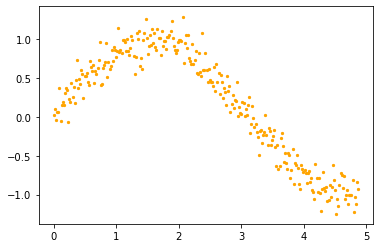

In [30]:
plt.scatter(data['x'], data['y'], c='orange', s=5);

As you can see, this dataset is noisy but has a clear relation between the input and the target. Let's fit a simple linear regression.

In [31]:
from sklearn.linear_model import LinearRegression

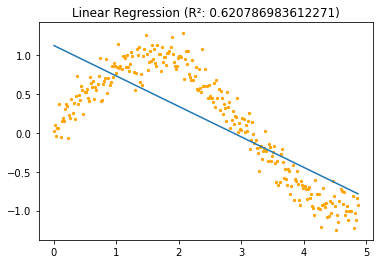

In [32]:
X = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression(normalize=True)
lr.fit(X, y)

plt.scatter(X['x'], data['y'], c='orange', s=5)
plt.plot(X['x'], lr.predict(X))
plt.title('Linear Regression (R²: {})'.format(lr.score(X, y)));

Clearly this models is underfit.

In order to try to get a better result, let's add extra inputs: **powers of `data['x']`** (aka polynomial features).

In [33]:
from utils import expand_dataset, fit_and_plot_linear_regression

In [34]:
data = expand_dataset(original_data, 3)
data.head(5)

,x,y,x^2
0,0.000000,0.022985,0.000000
1,0.017453,0.104006,0.000305
2,0.034907,-0.037130,0.001218
3,0.052360,0.064398,0.002742
4,0.069813,0.061009,0.004874


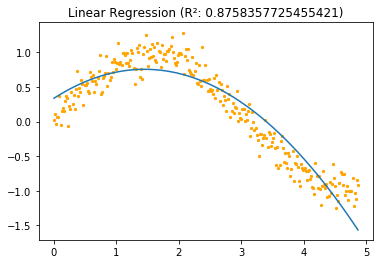

In [35]:
fit_and_plot_linear_regression(data)

We improved our R²! Let's get crazy and see what happens with many more powers

In [36]:
data = expand_dataset(original_data, 10)
data.head(5)

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9
0,0.000000,0.022985,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017453,0.104006,0.000305,0.000005,9.279177e-08,1.619522e-09,2.826599e-11,4.933346e-13,8.610313e-15,1.502783e-16
2,0.034907,-0.037130,0.001218,0.000043,1.484668e-06,5.182470e-08,1.809023e-09,6.314683e-11,2.204240e-12,7.694250e-14
3,0.052360,0.064398,0.002742,0.000144,7.516134e-06,3.935438e-07,2.060591e-08,1.078923e-09,5.649226e-11,2.957928e-12
4,0.069813,0.061009,0.004874,0.000340,2.375469e-05,1.658390e-06,1.157775e-07,8.082794e-09,5.642855e-10,3.939456e-11


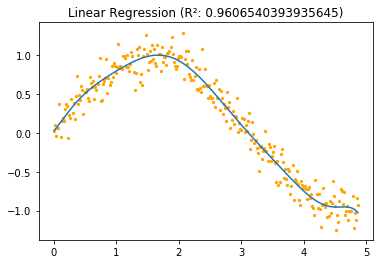

In [37]:
fit_and_plot_linear_regression(data)

Our $R^2$ is even better still!

Let's keep going with more powers!

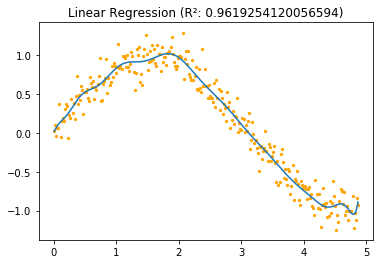

In [38]:
data = expand_dataset(original_data, 20)
fit_and_plot_linear_regression(data)

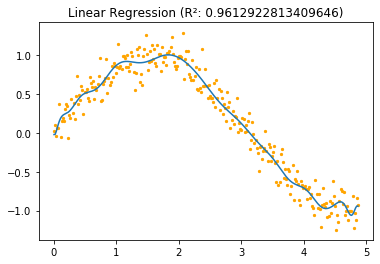

In [39]:
data = expand_dataset(original_data, 40)
fit_and_plot_linear_regression(data)

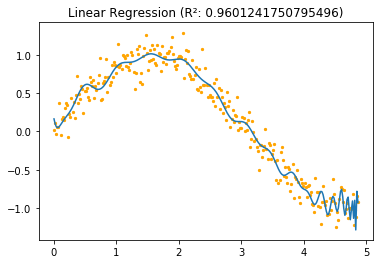

In [40]:
data = expand_dataset(original_data, 200)
fit_and_plot_linear_regression(data)

You might have noticed that the model, when adding a large number of this type of features, starts to fit to the noise as well! This means that a test set will, very likely, produce a really bad $R^2$, eventhough we are increasing the $R^2$ in the training set (also, remember that issue with noise fitting and $R^2$?). 

<a id='ridge'></a> [Top of section](#regularization)
## 3.2 Ridge Regularization ($L_2$ norm)

One thing that we can do to address this overfitting is apply $L_2$ regularization in our linear regression model. This means changing the loss function from the standard MSE
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$
to
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \|\beta\|_2^2$$
$$=$$
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \sum_{k=1}^K \beta_k^2$$

You'll notice that the left part of the loss function, $\frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$, is still MSE. By keeping this part in the loss function, the model will continue to try to reduce this amount. If this part is low, that indicates a good fit. If it is high, that indicates a bad fit. 

However, the new part of the function, $\lambda_2 \sum_{k=1}^K \beta_k^2$, is the sum of the squares of the betas, or the coefficients. The model will also try to reduce this amount, meaning the model will award smaller coefficients. If this part is low, that indicates a simple model. If it is high, that indicates a complex model.

Ideally we will have low values for both parts, resulting in a well-fitted, simple model.

In the $L_2$ loss function, $\lambda_2$ is the strength of the regularization part, which is a parameter that can be tuned. 

As you might have noticed, $\beta_0$ (i.e. the intercept) is excluded from the regularization expression (*k* starts at 1). 

This is due to certain theoretical aspects related to the intercept that are completely out of scope in here. If you are interested in knowing more about them, check the discussion in [stats.exchange.com](https://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression) or check this **bible** called [*Elements of Statistical Learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) (there is also a MOOC for this). 

We'll go through an example using a new class that implements this type of regularization: [Ridge](http://scikit-learn.org/0.18/modules/generated/sklearn.linear_model.Ridge.html).

In [41]:
from sklearn.linear_model import Ridge

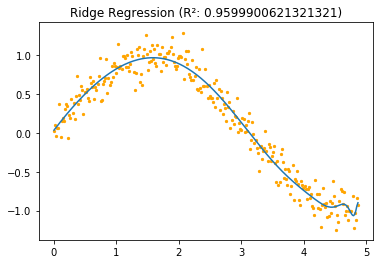

In [42]:
data = expand_dataset(original_data, 200)

X = data.drop('y', axis=1)
y = data['y']

# alpha here is the same as lambda in the loss function from above
ridge = Ridge(normalize=True, alpha=0.0001, random_state=10)
ridge.fit(X, y)

plt.scatter(X['x'], data['y'], c='orange', s=5)
plt.plot(X['x'], ridge.predict(X))
plt.title('Ridge Regression (R²: {})'.format(ridge.score(X, y)));

We can visualize the coefficients of the non-regularized Linear Regression and the regularized version to see what's happening:

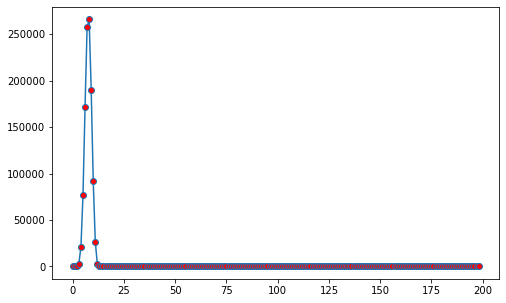

In [43]:
# No regularization
lr = LinearRegression(normalize=True)
lr.fit(X, y)
plt.figure(figsize = (8,5))
plt.plot(range(len(lr.coef_)), [abs(coef) for coef in lr.coef_], marker='o', markerfacecolor='r');

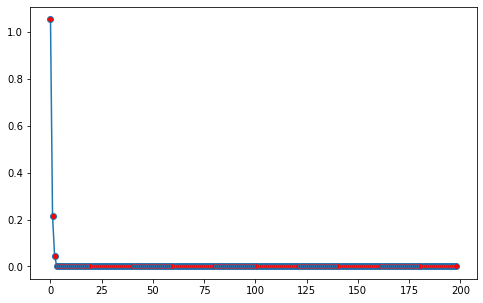

In [44]:
# With regularization
plt.figure(figsize = (8,5))
plt.plot(range(len(ridge.coef_)), [abs(coef) for coef in ridge.coef_], marker='o', markerfacecolor='r');

The Ridge model is clearly less overfit than the normal Linear Regression model, and only has 3-4 significant parameters, while the LR has 10-15!

From this, we see that another benefit of regularization can be increased **interpretability**. The regularized model automatically learns which features are important.

Let's increase the number of power features and see what happens

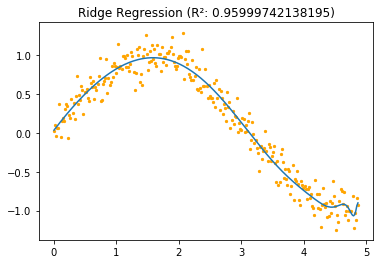

In [45]:
data = expand_dataset(original_data, 400)

X = data.drop('y', axis=1)
y = data['y']

ridge = Ridge(normalize=True, alpha=0.0001, random_state=10)
ridge.fit(X, y)

plt.scatter(X['x'], data['y'], c='orange', s=5)
plt.plot(X['x'], ridge.predict(X))
plt.title('Ridge Regression (R²: {})'.format(ridge.score(X, y)));

Interesting! Even after adding more features, out model didn't change (almost) anything! 

By the way, keep in mind that if we used the adjusted R², by this time, we would have an awful R² due to the number of useless features we have! If you don't believe us, let's check the coefficients

In [46]:
(ridge.coef_ == 0).sum() / ridge.coef_.shape[0]

0.43859649122807015

~44% of feature coefficients are 0! This means that those features are completely useless and, as desired, the adjusted R² would greatly penalize us!

<a id='lasso'></a> [Top of section](#regularization)
## 3.3 Lasso Regularization ($L_1$ norm)

Besides $L_2$, we also have $L_1$ regularization.

The loss function for $L_1$ is

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \|\beta\|_1^1$$
$$=$$
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$

This is usually called [Lasso regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). The difference between lasso and ridge is that instead of squaring the coefficients in ridge, lasso uses the absolute value of the coefficients. This type of regression is way more aggressive in its approach to constraining coefficient magnitude. In many real world scenarios, it usually has just a few features with coefficients different from 0. 

Let's repeat the same examples, this time using Lasso.

In [47]:
from sklearn.linear_model import Lasso

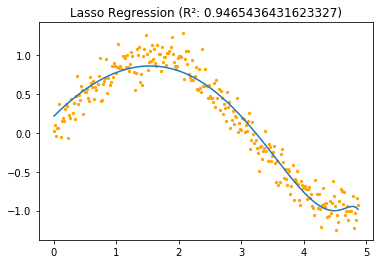

In [48]:
data = expand_dataset(original_data, 200)

X = data.drop('y', axis=1)
y = data['y']

# alpha here is the same as lambda in the loss function from above
lasso = Lasso(normalize=True, alpha=0.0002, random_state=10)
lasso.fit(X, y)

plt.scatter(X['x'], data['y'], c='orange', s=5)
plt.plot(X['x'], lasso.predict(X))
plt.title('Lasso Regression (R²: {})'.format(lasso.score(X, y)));

Let's visualize the coefficients of the fitted model:

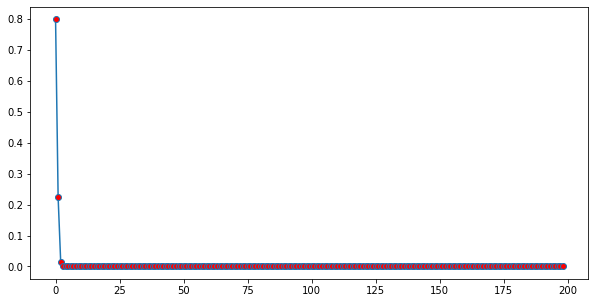

In [49]:
plt.figure(figsize = (10,5))
plt.plot(range(len(lasso.coef_)), [abs(coef) for coef in lasso.coef_], marker='o', markerfacecolor='r')

Like we saw with Ridge, just a few features (the lowest-order polynomials) are significant, and all other features are zero!

<a id='elasticnet'></a> [Top of section](#regularization)
## 3.4 Elastic Net Regularization ($L_1 + L_2$ norm)

Also, finally, we can have both $L_1$ and $L_2$ in what is called [Elastic Net regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

The loss function for elastic net just adds the extra parts we added in ridge and lasso:

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right| + \lambda_2 \sum_{k=1}^K \beta_k^2$$

We'll repeat the same example again using Elastic Net. This time `alpha` is the total weight of the penalty terms ($\lambda_1 + \lambda_2$), and we can also set the ratio of $\lambda_1$ to $\lambda_2$ with `l1_ratio`.

In [50]:
from sklearn.linear_model import ElasticNet

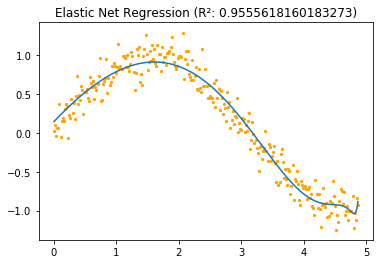

In [51]:
data = expand_dataset(original_data, 200)

X = data.drop('y', axis=1)
y = data['y']

# alpha here is the same as lambda in the loss function from above
en = ElasticNet(normalize=True, alpha=0.00001, l1_ratio=0.5, random_state=10)
en.fit(X, y)

plt.scatter(X['x'], data['y'], c='orange', s=5)
plt.plot(X['x'], en.predict(X))
plt.title('Elastic Net Regression (R²: {})'.format(en.score(X, y)));